# Import Libraries

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.stats import zscore
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Define Dataset

In [31]:
df = pd.read_csv("breast-cancer_cleaned.csv")
df

,texture_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,-2.073335,2.217515,2.255747,-0.565265,-0.321821,-0.214002,0.724026,0.660820,1.148757,0.907083,1.307686,1.139636,1.937015,1
1,-0.353632,0.001392,-0.868652,-0.876244,0.742402,-0.605351,-0.440780,0.260162,-0.805450,-0.099444,-0.375612,-0.243890,0.281190,1
2,0.456187,0.939685,-0.398008,-0.780083,0.557852,-0.297005,0.213076,1.424827,0.237036,0.293559,0.527407,1.152255,0.201391,1
3,0.253732,0.155462,0.046836,-0.110409,-0.288378,0.689702,0.819518,1.115007,-0.069777,0.267687,0.749217,-0.115114,0.230872,1
4,-1.151816,-0.009560,-0.562450,-0.790244,0.156716,1.483067,0.828471,1.144205,-0.361092,0.499328,0.220556,-0.868353,-0.397100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.721473,-0.312589,-0.931027,0.071025,0.350640,1.086384,0.666001,2.067178,-1.138416,0.167980,0.378365,-1.360158,-0.709091,1
565,2.085134,-0.217664,-1.058611,0.322856,-0.131594,-0.424010,0.252202,0.808431,-0.189161,-0.490556,-0.691230,-0.531855,-0.973978,1
566,2.045574,-0.809117,-0.895587,-0.257371,0.180698,-0.379342,0.510827,0.612157,-0.891416,0.036727,-0.809587,-1.104549,-0.318409,1
567,2.336457,2.137194,1.043695,0.686088,0.183955,-0.173000,1.302285,0.785721,0.326634,0.904057,1.430427,1.919083,0.936537,1


# Build Model

### Simple Train-Test Split

In [65]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [67]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=np.unique(y_true))
    disp.plot(cmap='Blues', values_format=".2f")  # Display values with 2 decimal places
    plt.title(f"Confusion Matrix for {model_name} (Percentage)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    results = classification_report(y_true, y_pred)
    print(results)
    print("Accuracy:", accuracy_score(y_true, y_pred))

In [68]:
def plot_hyperparameter_results(grid_search, model_name):
    # Extract results
    results = grid_search.cv_results_

    # Get mean training and validation scores
    mean_train_scores = results['mean_train_score']  # Training accuracy
    mean_val_scores = results['mean_test_score']    # Validation accuracy
    param_combinations = results['params']          # Hyperparameter combinations

    # Create indices for each configuration
    indices = np.arange(len(param_combinations))

    # Plot training and validation accuracy
    plt.figure(figsize=(20, 7))
    plt.plot(indices, mean_train_scores, marker='o', linestyle='-', color='blue', label='Training Accuracy')
    plt.plot(indices, mean_val_scores, marker='o', linestyle='--', color='orange', label='Validation Accuracy')

    # Annotate configurations on the plot
    for i, params in enumerate(param_combinations):
        plt.text(indices[i], mean_val_scores[i], str(params), fontsize=7, rotation=45, ha='left', color='black')

    # Add labels, legend, and grid
    plt.xlabel('Hyperparameter Configuration Index')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy vs. Hyperparameter Configuration ({model_name})')
    plt.xticks(indices, labels=indices)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Decision Tree

In [78]:
# features at the top of the tree are often more prominent.

In [77]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [79]:
# Hyperparameter grid for tuning the Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],     # Use both Gini impurity and entropy for splitting nodes
    'max_depth': [3, 4, 5],               # Test different maximum depths of the tree
    'min_samples_split': [35, 45],        # Minimum samples required to split an internal node
    'min_samples_leaf': [15, 20],         # Minimum samples required to be at a leaf node
    'ccp_alpha': [0.02, 0.04]             # Pruning parameter to control overfitting
}

In [80]:
# Initialize the Decision Tree model with a fixed random seed for reproducibility
dt_model = DecisionTreeClassifier(random_state=42)

In [81]:
# Set up GridSearchCV to tune hyperparameters
dt_grid_search = GridSearchCV(
    estimator = dt_model,               # Decision Tree model
    param_grid=dt_param_grid,           # Hyperparameter grid for tuning
    scoring='accuracy',                 # Evaluate model based on accuracy score
    cv=5,                               # 5-fold cross-validation
    return_train_score=True,            # Return training scores
    n_jobs=-1,                          # Use all CPU cores for parallel processing
    verbose=2                           # Display progress during the search
)

In [82]:
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.02, 0.04],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [15, 20],
                         'min_samples_split': [35, 45]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [83]:
# Get the best model based on the grid search
best_dt_model = dt_grid_search.best_estimator_
dt_grid_search.best_params_

{'ccp_alpha': 0.04,
 'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 15,
 'min_samples_split': 35}

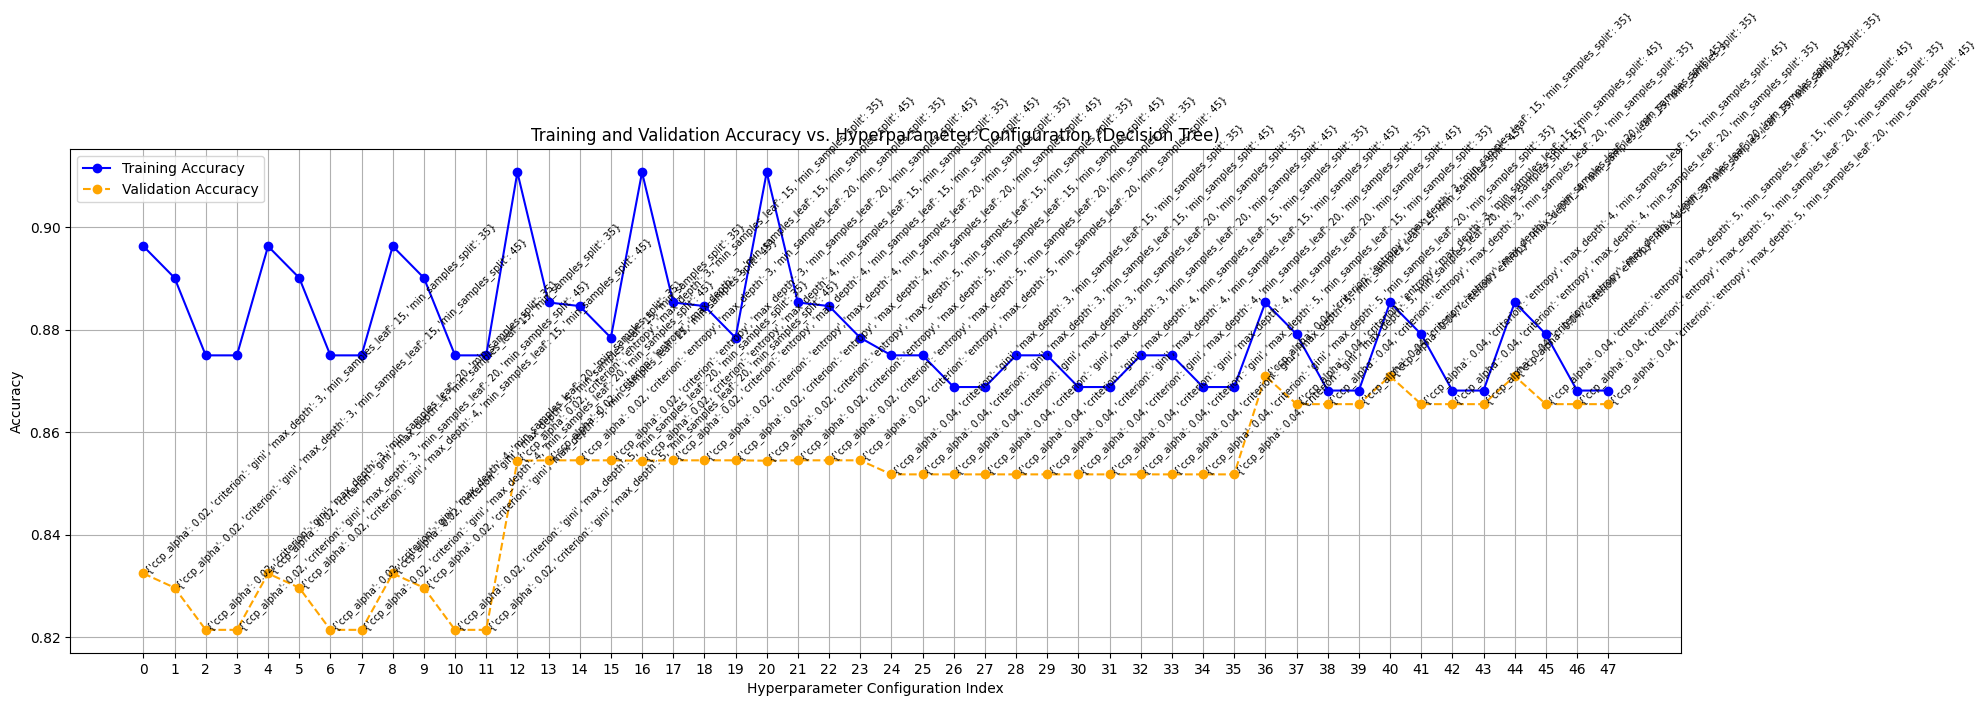

In [84]:
plot_hyperparameter_results(dt_grid_search, "Decision Tree")

In [85]:
# Predict labels for the validation set using the best Decision Tree model
y_val_pred_dt = best_dt_model.predict(X_val)
# Evaluate the model on the validation set
evaluate_model(y_val, y_val_pred_dt, "Tuned Decision Tree")


Tuned Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90        58
           1       0.96      0.67      0.79        33

    accuracy                           0.87        91
   macro avg       0.90      0.82      0.85        91
weighted avg       0.88      0.87      0.86        91

Accuracy: 0.8681318681318682


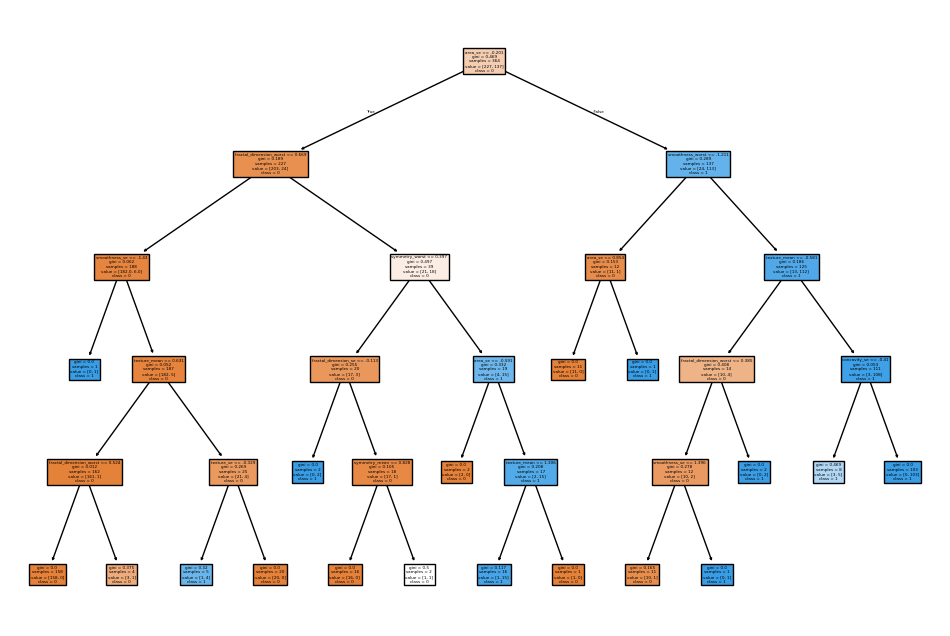

In [86]:
plt.figure(figsize=(12, 8))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=["0", "1"],  # Explicitly provide class names as strings
    filled=True
)
plt.show()

## KNN (K-Nearest Neighbors)

In [87]:
# Define a dictionary for hyperparameter tuning
knn_param_grid = {
    # List of possible values for the number of neighbors to consider during classification
    'n_neighbors': [3, 5, 7, 9, 11],

    # Set the 'weights' parameter to 'uniform', meaning each neighbor has an equal weight in the prediction
    'weights': ['uniform'],

    # List of distance metrics to use when calculating the distance between data points
    'metric': ['euclidean', 'manhattan']
}

In [88]:
# Create KNN classifier model
knn_model = KNeighborsClassifier()

# Set up GridSearchCV to search for the best hyperparameters
knn_grid_search = GridSearchCV(
    estimator=knn_model,                # KNN model
    param_grid=knn_param_grid,          # Hyperparameter grid to search
    scoring='f1_weighted',              # Use F1 weighted score as evaluation metric
    cv=5,                               # 5-fold cross-validation
    return_train_score=True             # Return training scores
)

In [89]:
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform']},
             return_train_score=True, scoring='f1_weighted')

In [90]:
best_knn_model = knn_grid_search.best_estimator_
knn_grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

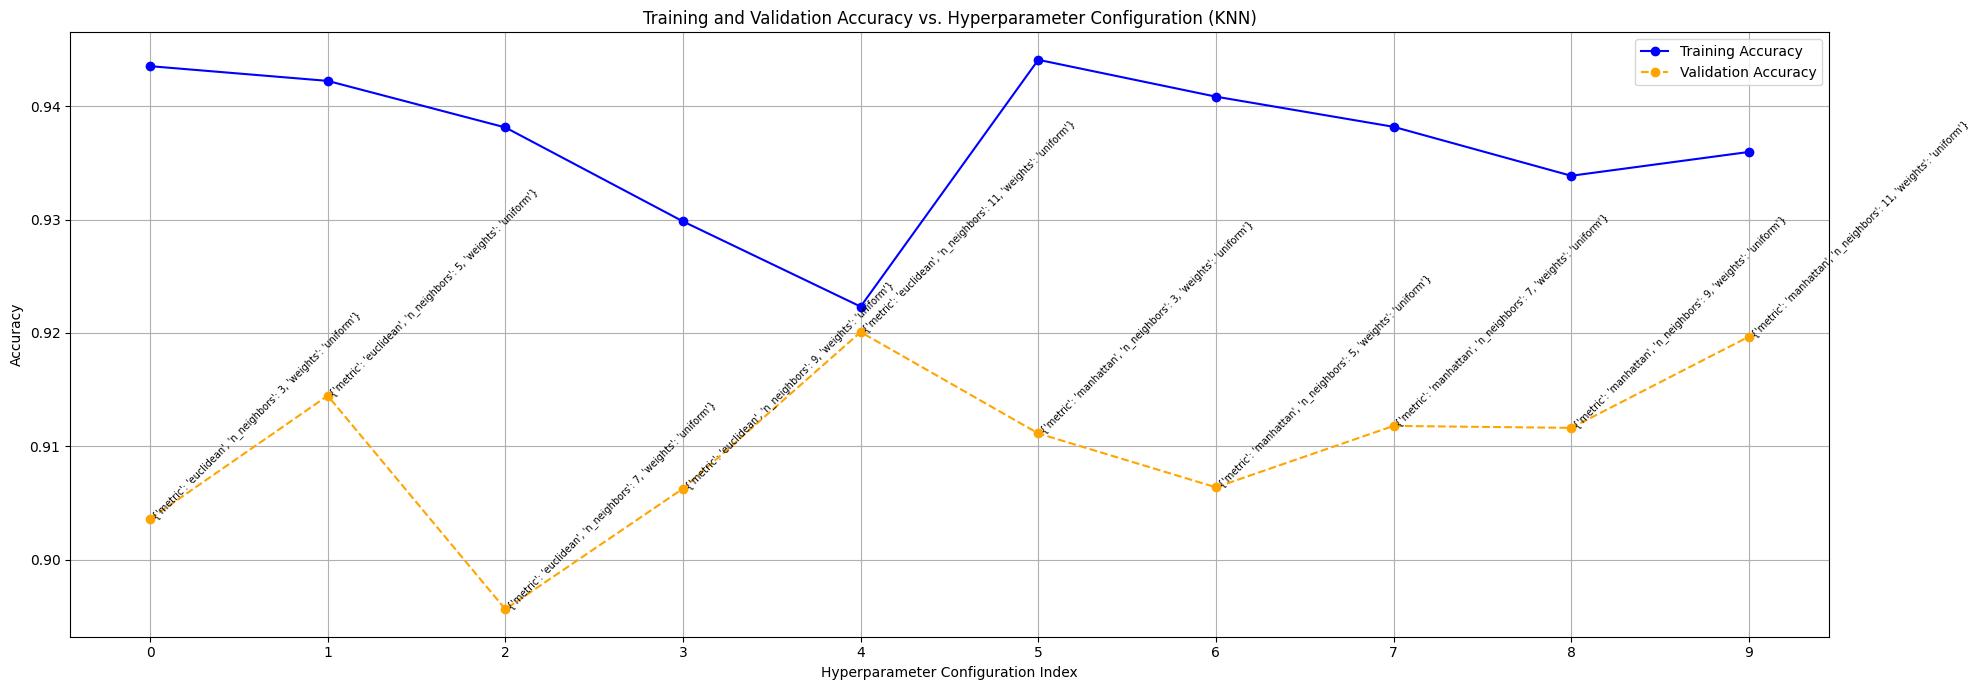

In [91]:
plot_hyperparameter_results(knn_grid_search, "KNN")

In [92]:
# Predict labels for the validation set using the best KNN model
y_val_pred_knn = best_knn_model.predict(X_val)
# Evaluate the performance of the tuned KNN model on validation set
evaluate_model(y_val, y_val_pred_knn, "Tuned KNN")


Tuned KNN Performance:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        58
           1       0.93      0.82      0.87        33

    accuracy                           0.91        91
   macro avg       0.92      0.89      0.90        91
weighted avg       0.91      0.91      0.91        91

Accuracy: 0.9120879120879121


## Naive Bayes

In [93]:
# Define hyperparameter grids for Naive Bayes
nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

In [94]:
# Set up GridSearchCV for Naïve Bayes
nb_model = GaussianNB()
nb_grid_search = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, scoring='f1_weighted', cv=5,return_train_score=True)

In [95]:
nb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             return_train_score=True, scoring='f1_weighted')

In [96]:
print("Best parameters for Naïve Bayes:", nb_grid_search.best_params_)
best_nb_model = nb_grid_search.best_estimator_
y_val_pred_nb = best_nb_model.predict(X_val)

Best parameters for Naïve Bayes: {'var_smoothing': 1e-09}


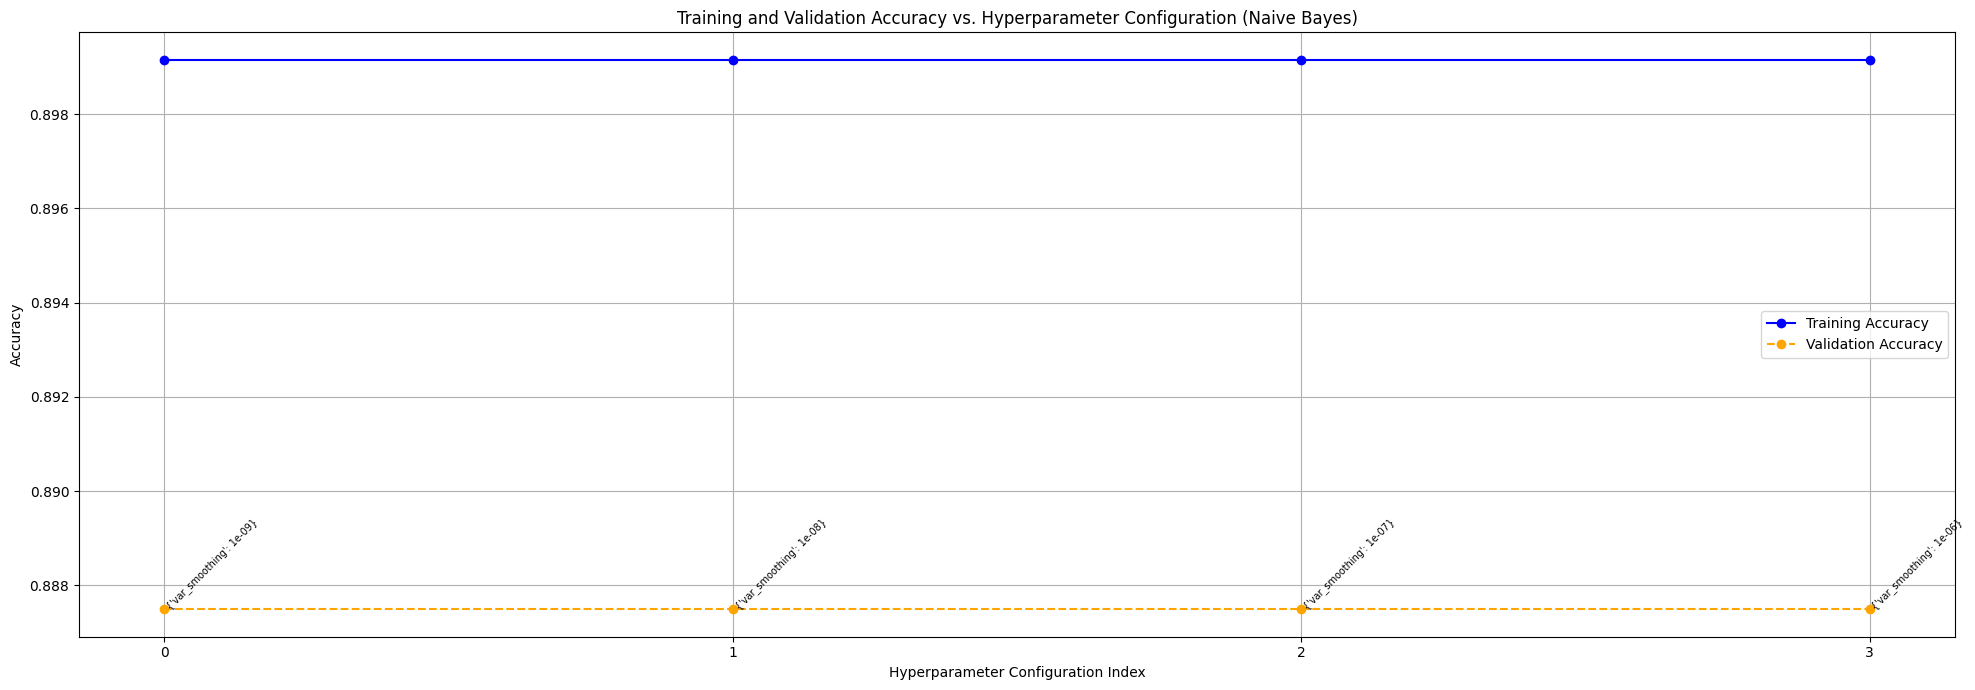

In [97]:
plot_hyperparameter_results(nb_grid_search, "Naive Bayes")

In [98]:
evaluate_model(y_val, y_val_pred_nb, "Tuned Naïve Bayes")


Tuned Naïve Bayes Performance:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        58
           1       0.86      0.91      0.88        33

    accuracy                           0.91        91
   macro avg       0.90      0.91      0.91        91
weighted avg       0.91      0.91      0.91        91

Accuracy: 0.9120879120879121


# compare the evaluation metrics